In [6]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

operating_system = 'mac'

if operating_system == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')
elif operating_system == 'curnagl':
    os.chdir('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/')
else:
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')

# Add the path to the custom library
custom_library_path = os.path.abspath('util/processing/')
sys.path.append(custom_library_path)

#custom_library_path = os.path.abspath('util/gev/')
#sys.path.append(custom_library_path)

import time_series#, vgam_loader

'''if operating_system == 'curnagl':
    name_of_variable= pd.read_csv('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/DATASETS/variable_list_80_mean.csv')
    path_data = '/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/DATASETS'
else:'''
name_of_variable= pd.read_csv('data/variable_list_levels.csv')
path_data = 'data'

storm_dates = pd.read_csv('pre_processing/tracks/storm_dates.csv')
path_tracks_1h = 'pre_processing/tracks/ALL_TRACKS/tracks_1h'
#path_tracks_1h_non_EU = 'pre_processing/tracks/ALL_TRACKS/tracks_1h_non_EU'
dataset = 'datasets_1h'
#dataset_non_EU = 'datasets_1h_non_EU'

In [13]:
# response value (or extreme value) taken from the storm landfall

vivian = time_series.tif_to_dataframe('data/timeseries_rasters_storms/5_VIVIAN.tif', '02_02_90')
climato_vivian = time_series.tif_to_dataframe('data/climatology/instantaneous_10m_wind_gust_cut/max_winds_europe_2_2_cut.tif', '02_02')

# drop rows with nan values
vivian = vivian.dropna()
climato_vivian = climato_vivian.dropna()

# wind values only
vivian = vivian.iloc[:,0]
climato_vivian = climato_vivian.iloc[:,0]
# export the frist column of each dataframe
vivian.to_csv('data/test/5_VIVIAN.csv')
climato_vivian.to_csv('data/test/max_winds_europe_2_2_cut.csv')


Shape (ξ): -0.016526964322857197, Location (μ): 10.189933794663704, Scale (σ): 1.2268576993468128


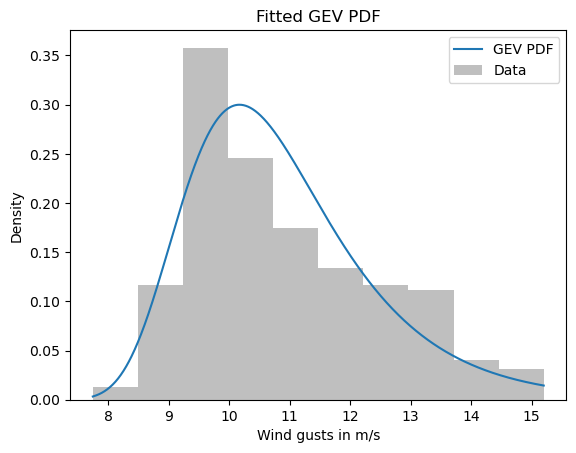

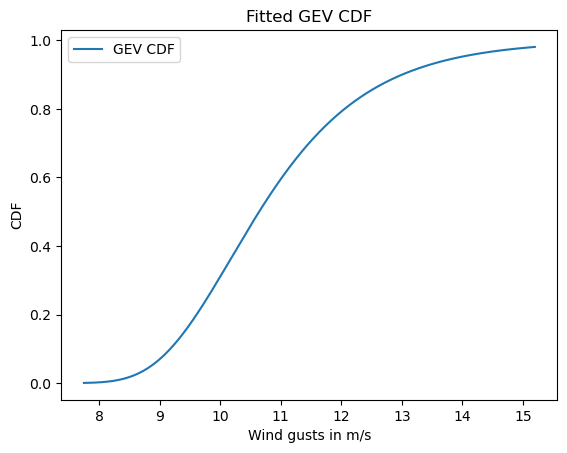

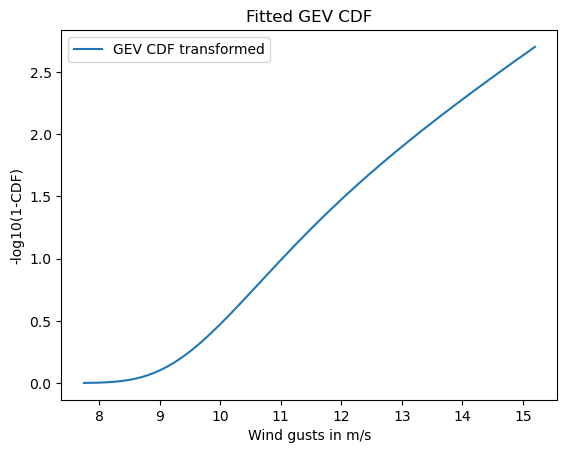

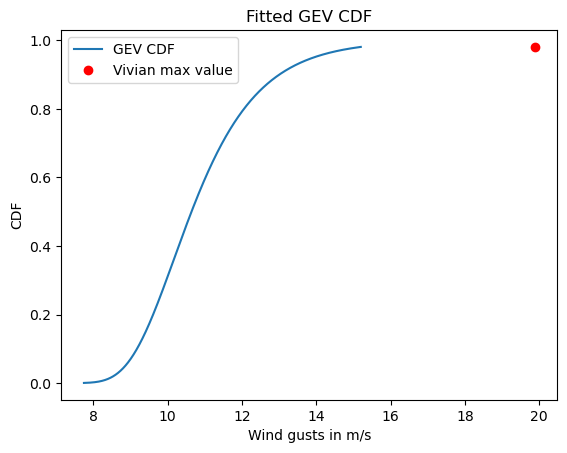

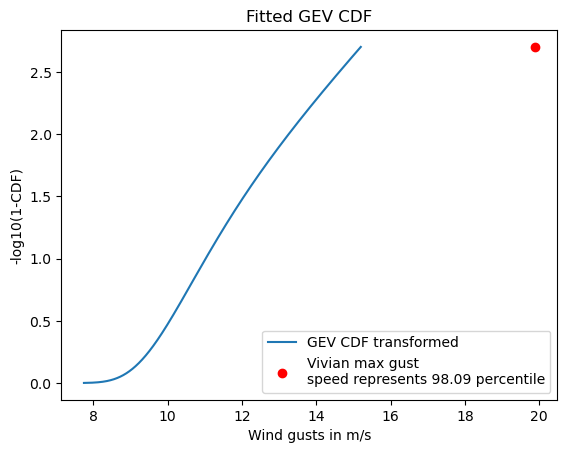

In [70]:
import numpy as np
from scipy.stats import genextreme

# Example data: yearly maxima
data = climato_vivian[:300]
vivian_subset = vivian[:300]

# Fit the GEV distribution
shape, loc, scale = genextreme.fit(data)

print(f"Shape (ξ): {shape}, Location (μ): {loc}, Scale (σ): {scale}")

# Plot the PDF
import matplotlib.pyplot as plt

x_vals = np.linspace(min(data), max(data), 1000)
pdf_vals = genextreme.pdf(x_vals, shape, loc=loc, scale=scale)
cdf_vals = genextreme.cdf(x_vals, shape, loc=loc, scale=scale)

# tranform it with target - log10(1-CDF)
cdf_vals_tranformed = cdf_vals-np.log10(1-cdf_vals)

plt.plot(x_vals, pdf_vals, label="GEV PDF")
plt.hist(data, bins=10, density=True, alpha=0.5, color="gray", label="Data")
plt.legend()
plt.title("Fitted GEV PDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("Density")
plt.show()

# Plot the CDF
plt.plot(x_vals, cdf_vals, label="GEV CDF")
plt.legend()
plt.title("Fitted GEV CDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("CDF")
plt.show()


plt.plot(x_vals, cdf_vals_tranformed, label="GEV CDF transformed")
plt.legend()
plt.title("Fitted GEV CDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("-log10(1-CDF)")
plt.show()

# find the max value of the storm data (Vivian)
max_vivian = vivian_subset.max()

# find to what percentile the max_vivian value corresponds in the GEV distribution
percentile_CDF = cdf_vals[np.argmin(np.abs(x_vals - max_vivian))]
percentile_CDF_transformed = cdf_vals_tranformed[np.argmin(np.abs(x_vals - max_vivian))]

# plot them on the CDF and CDF transformed
plt.plot(x_vals, cdf_vals, label="GEV CDF")
plt.plot(max_vivian, percentile_CDF, 'ro', label="Vivian max value")
plt.legend()
plt.title("Fitted GEV CDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("CDF")
plt.show()

plt.plot(x_vals, cdf_vals_tranformed, label="GEV CDF transformed")
plt.plot(max_vivian, percentile_CDF_transformed, 'ro', label=f"Vivian max gust\nspeed represents {percentile_CDF*100:.2f} percentile")
plt.legend()
plt.title("Fitted GEV CDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("-log10(1-CDF)")
plt.show()

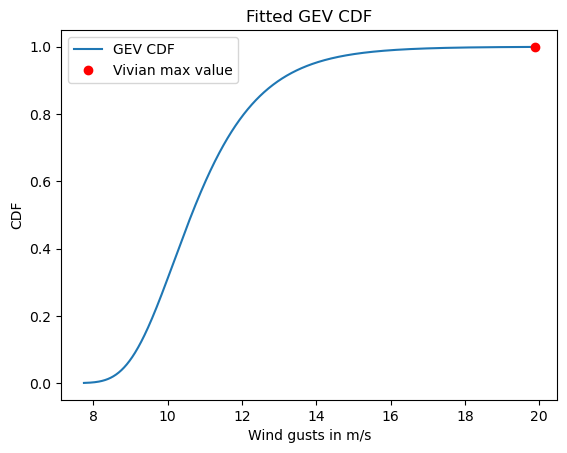

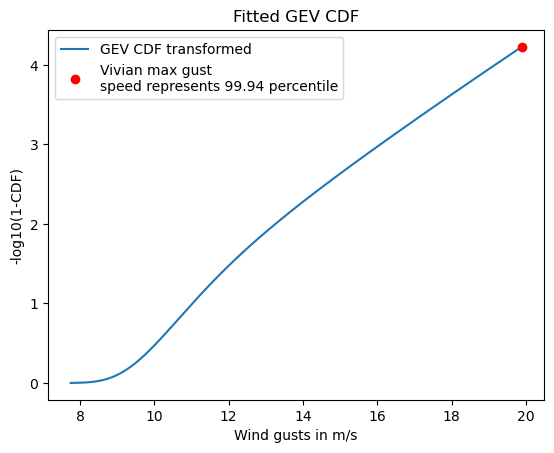

In [67]:
# now expand the x_vals to the whole range of the maxima
x_vals_extended = np.linspace(min(data), max(vivian_subset), 1000)
cdf_vals_extended = genextreme.cdf(x_vals_extended, shape, loc=loc, scale=scale)
# tranform it with target - log10(1-CDF)
cdf_vals_tranformed_extended = cdf_vals_extended-np.log10(1-cdf_vals_extended)

percentile_extended = cdf_vals_extended[np.argmin(np.abs(x_vals_extended - max_vivian))]
percentile_CDF_transformed_extended = cdf_vals_tranformed_extended[np.argmin(np.abs(x_vals_extended - max_vivian))]

# plot them on the CDF and CDF transformed
plt.plot(x_vals_extended, cdf_vals_extended, label="GEV CDF")
plt.plot(max_vivian, percentile_extended, 'ro', label="Vivian max value")
plt.legend()
plt.title("Fitted GEV CDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("CDF")
plt.show()

plt.plot(x_vals_extended, cdf_vals_tranformed_extended, label="GEV CDF transformed")
plt.plot(max_vivian, percentile_CDF_transformed_extended, 'ro', label=f"Vivian max gust\nspeed represents {percentile_extended*100:.2f} percentile")
plt.legend()
plt.title("Fitted GEV CDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("-log10(1-CDF)")
plt.show()

In [69]:
# calculate the return period of the storm
return_period = 1/(1-percentile_extended)
print(f"The return period of the storm Vivian is {return_period:.2f} years")

The return period of the storm Vivian is 1680.75 years
